# How to make custom dataset?
# How to use LSTM model with pytorch?
# How to initialize LSTM model hidden state?

In [1]:
import pandas as pd
#구글이나 야후 파이낸스 서버에 접속해 주가 데이터를 api를 이용해 받아 올 수 있음
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.13.0
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Pandas Datareader Test

<AxesSubplot:xlabel='Date'>

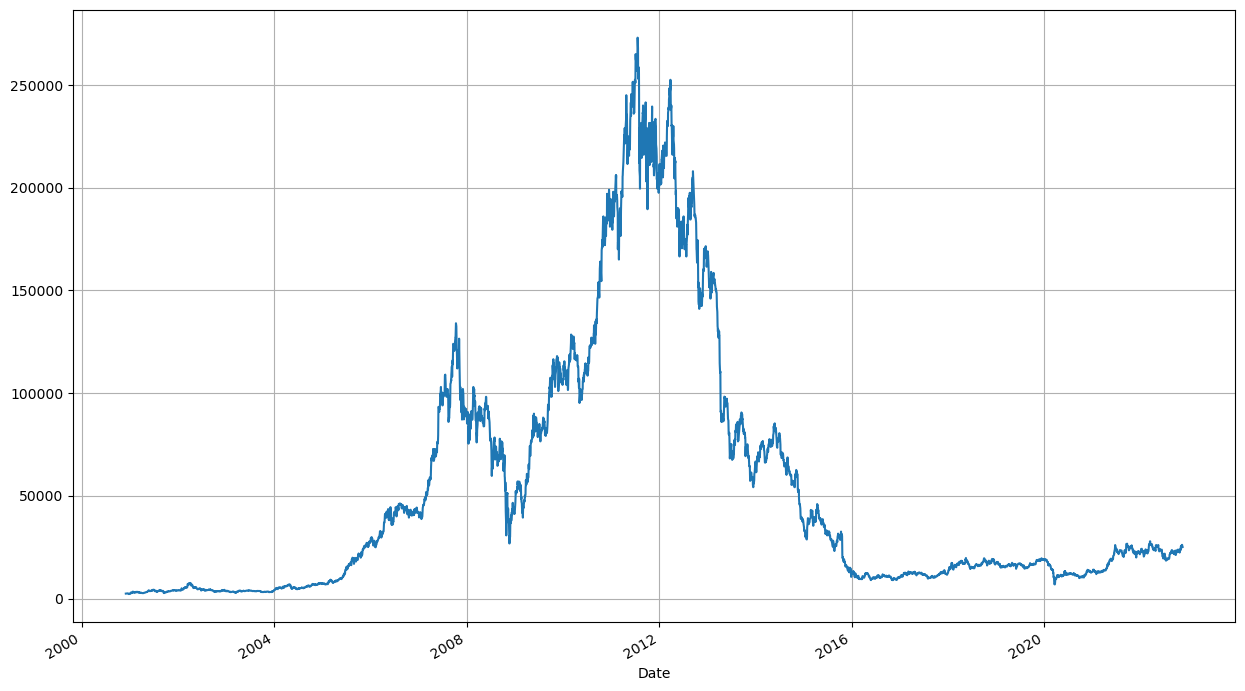

In [2]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = (2000, 12, 1)
# *start => start에 있는 인자를 하나씩 하나씩 각각 순서대로 넣어주겠다
start = datetime.datetime(*start)   # 2000년 12월 1일
end = datetime.date.today() # 2019 02 14 4531 rows X 6 columns

# 어떤주식종목을가져올것인가, 어떤서비스제공자로부터가져올것인가, 며칠부터 며칠까지의 데이터를 가져올 것인가(datatime object)
google = pdr.DataReader('028050.KS', 'yahoo', start, end)

#Low 의 columns을 가져와 matplotlib.pyplot.plot 으로 바로 연결해줌
google.Low.plot(grid=True)

In [3]:
google.tail()
print(google.isna().sum())
print(google)

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
               High      Low     Open    Close     Volume     Adj Close
Date                                                                   
2000-12-01   2500.0   2420.0   2495.0   2500.0   222800.0   1927.813110
2000-12-04   2560.0   2450.0   2500.0   2470.0   196100.0   1904.679199
2000-12-05   2500.0   2455.0   2455.0   2485.0   158800.0   1916.246094
2000-12-06   2580.0   2490.0   2530.0   2490.0   287600.0   1920.101807
2000-12-07   2490.0   2455.0   2470.0   2465.0   147900.0   1900.823608
...             ...      ...      ...      ...        ...           ...
2022-11-14  27450.0  26150.0  27250.0  26350.0  1496906.0  26350.000000
2022-11-15  26650.0  25800.0  26500.0  26050.0  1026913.0  26050.000000
2022-11-16  26550.0  25600.0  26250.0  26500.0  1410737.0  26500.000000
2022-11-17  26750.0  25200.0  26600.0  25200.0  1597801.0  25200.000000
2022-11-18  25750.0  25100.0  252

# Dataset, DataLoader 연습

## Dataset -> X[i], Y[i] i번째 data를 return

## Dataloader -> batch를 만들어줌

In [4]:
# class dummySet(Dataset):
    
#     def __init__(self, num_data):
#         self.x = np.array(list(range(num_data*2))).reshape(-1, 2)
#         self.y = np.array(list(range(num_data)))
        
#     def __len__(self):
#         return len(self.x)  # self.x.size()[0]
    
#     def __getitem__(self, idx):
#         return self.x[idx, :], self.y[idx]

In [5]:
# dataset = dummySet(100)
# dataloader = DataLoader(dataset, 3, shuffle=True, drop_last=True)
# #중복없이 random으로 sampling 해줌 (permutation)
# #마지막 배치는 버림(batch_size가 안맞을 수도 있음), lstm의 경우에는 batch_size에 dependent하게 만들기때문

In [6]:
# for batch in dataloader:
#     X = batch[0]
#     y = batch[1]
#     print(X, y)
#     break

# for X, y in dataloader:
#     print(X.shape, y.shape)

# Data Preparation

In [7]:
class StockDataset(Dataset):
    # X : [10, n, 6] -> [n, 10, 6]
    # y : [10, m, 1] or [10, m]
    
    #초기화를 하는 부분
    #x_frames, y_frames -> x와 y의 시퀀스 개수 n, m
    def __init__(self, symbol, x_frames, y_frames, start, end):
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)
        
        self.data = pdr.DataReader(self.symbol, 'yahoo', self.start, self.end)
        #dataframe 안에 na 값이 얼마나 있는 지 알려줌
        print(self.data.isna().sum())
    
    #배치를 만들때 dataset이 얼마나 큰 지 알아야함!
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    #i번째 data 반환 (인덱싱을 하는 문법)
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        #columns의 순서를 맞춤
        data = data[['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']]
        # normalization (추세의 관점으로 보고싶음) (변동추이)
        # log의 차이로 나눠줌
        # 최근 마지막 n일 가격의 log값과 각각의 날짜에 log를 씌운 값의 차이로 x_seq, y_seq를 변형시키겠다.
        """
        1 -> log(1) - log(2)   log(1) - log(2) = log(a/b) => 나누기와 거의 유사한 normalization이 됨 
                                (나누기로 하지 않은 이유는 merical한 stability을 위해 이런식으로 식을 변형함)
        1 -> log(1) - log(2)
        2 -> log(2) - log(2)
        2 -> log(2) - log(2)        
        """
        # log(0) -> infinite => x를 x+1로 바꿔줌
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        #dataframe을 numpy array로 convert
        data = data.values
        
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [8]:
dataset = StockDataset('028050.KS', 10, 5, (2001, 1, 1), (2005, 1, 1))
dataloader = DataLoader(dataset, 2, drop_last = True, shuffle=True)
for X, y in dataloader:
    print(X.shape, y.shape)
    break
#X와 y를 seqence로 샘플링을 할 수 있게 됨

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
torch.Size([2, 10, 6]) torch.Size([2, 5, 6])


# Model Define

In [9]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    #hid_dim -> output_dim (MLP)
    #MLP를 만드는 함수
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        #lstm_out => 각 time step에서의 lstm model의 output을 내보내고 있는 값
        #self.hidden => 각각의 layer의 모든 hidden state를 갖고 있는 값 (layer가 많아지면 ht가 layer마다 생김)
        #공식문서 참고!
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        #맨 마지막 가격까지 들어가고 그것까지 다 처리가 된 hidden vector을 가지고 예측하고 싶어하니 -1을 선택(맨 마지막 output)
        #그리고 batch_size로 잘 reshape된 값을 regressor에 넣어서 가격을 예측하는 구조임
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [10]:
#차이의 절댓값의 합으로 모델을 마지막에 평가하기 위해 만듬 (accuracy)
#우리가 이해할 수 있는 성능지표로 바꾸자
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

# Train, Validate, Test

In [11]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], batch_size=args.batch_size, shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    # acc -> 위에서 정의한 함수인 metric값이됨
    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        #LSTM -> (seq, batch_size, input_dim)
        X = X.transpose(0, 1).float().to(args.device)
        #close,, 종가 선택
        y_true = y[:, :, 3].float().to(args.device)
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [12]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [13]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [14]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment

In [15]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [16]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [19]:
#trainset, valset, testset 나눠줌
trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2012,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2012,1,1), (2016,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


In [20]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 128
args.x_frames = 5
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 2


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_lr', device='cuda', symbol='028050.KS', batch_size=128, x_frames=5, y_frames=5, input_dim=6, hid_dim=50, n_layers=1, l2=1e-05, dropout=0.0, use_bn=True, optim='RMSprop', lr=0.001, epoch=2)
Epoch 0, Acc(train/val): 4.92/4.34, Loss(train/val) 0.00981/0.00527. Took 3.94 sec
Epoch 1, Acc(train/val): 2.71/3.14, Loss(train/val) 0.00347/0.00392. Took 3.79 sec
Namespace(exp_name='exp1_lr', device='cuda', symbol='028050.KS', batch_size=128, x_frames=5, y_frames=5, input_dim=6, hid_dim=50, n_layers=2, l2=1e-05, dropout=0.0, use_bn=True, optim='RMSprop', lr=0.001, epoch=2)
Epoch 0, Acc(train/val): 4.97/5.73, Loss(train/val) 0.01461/0.00456. Took 3.78 sec
Epoch 1, Acc(train/val): 3.02/4.63, Loss(train/val) 0.00374/0.00370. Took 3.75 sec
Namespace(exp_name='exp1_lr', device='cuda', symbol='028050.KS', batch_size=128, x_frames=5, y_frames=5, input_dim=6, hid_dim=50, n_layers=3, l2=1e-05, dropout=0.0, use_bn=True, optim='RMSprop', lr=0.001, epoch=2)
Epoch 0, Acc(train/val): 4

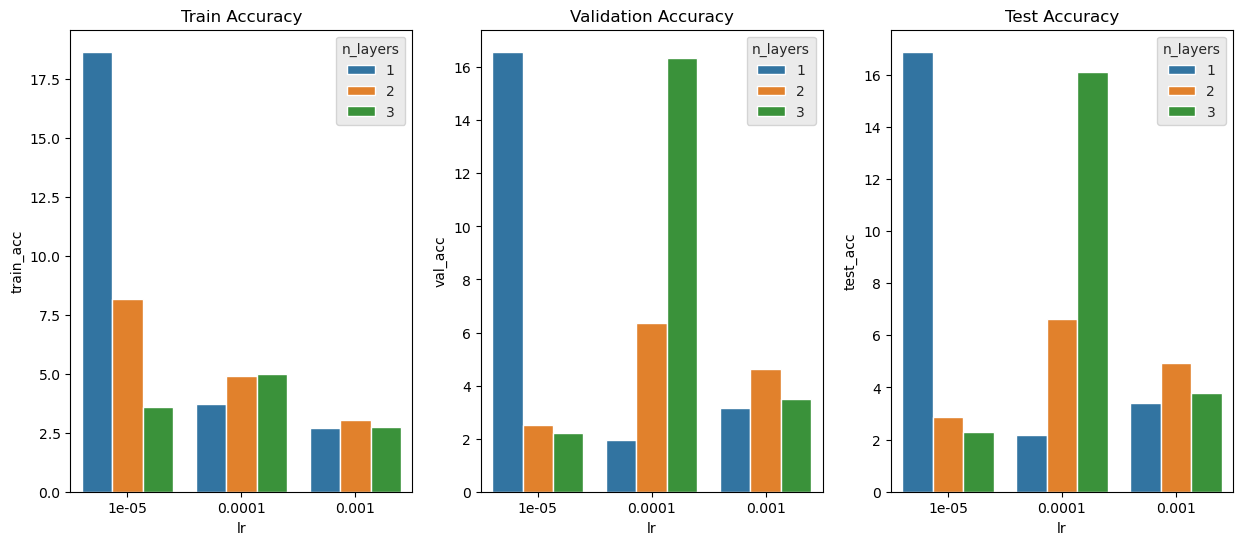

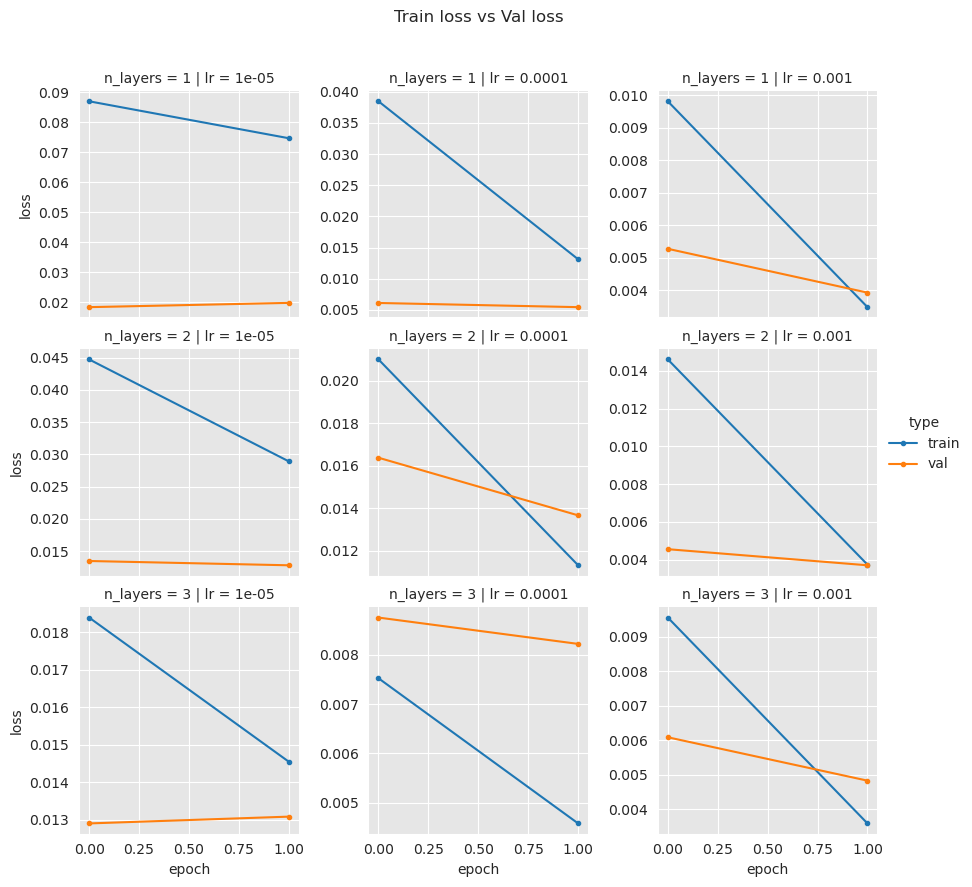

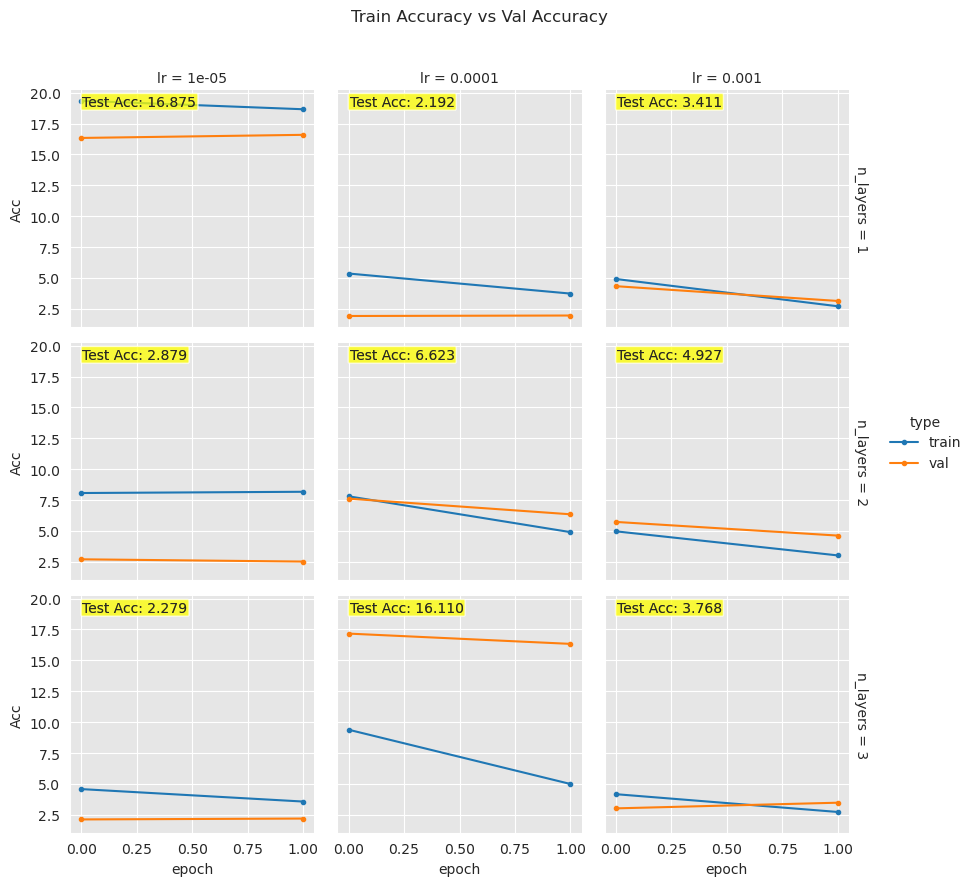

In [21]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)